In [36]:
import pandas as pd
import numpy as np
import ndjson
import jsonlines
import json
import pickle
import os
import sys
import random as rd
import json
import re, regex
from joblib import dump, load
import collections
import math
import statistics
import itertools

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [37]:
path = '../Data/pan19-celebrity-profiling-training-dataset-2019-01-31/stratified_subsample/'

subana = ['org/', 'min_tweets_1000/', 'complete_balance/']

subsets = [200, 500, 1000, 2000]

classifiers = ['SVM']

datafolder = 'split_data/'

ml_results = 'ml/'

filebeg = 'stratified_subsample_'


labels = ['age', 'gender', 'author']

phases = ['child_21', 'young_adult_35', 'adult_50', 'old_adult_65', 'retiree']



In [38]:
####tester

subana = ['complete_balance/']

subsets = [200]

classifiers = ['SVM']

datafolder = 'split_data/'

ml_results = 'ml/'

filebeg = 'stratified_subsample_'

labels = ['age', 'gender', 'author']

In [39]:
def identity_tokenizer(text):
    return text




df_dic = {}
res_dic = {}
author_dic = {}

for st in subsets:

    res_dic[st] = {}
   
    df_dic[st] = {}
    author_dic[st] = {}
    for ana in subana:
        
        res_dic[st][ana.split('/')[0]] = {}
        df_dic[st][ana.split('/')[0]] = {}
        author_dic[st][ana.split('/')[0]] = {}
        ###make dic with all authors
        with open(path+ana+str(st)+'/'+datafolder+filebeg+str(st)+'_author_train.json', 'r', encoding='utf-8') as f:
            authors = json.load(f)
        with open(path+ana+str(st)+'/'+datafolder+filebeg+str(st)+'_gender_train.json', 'r', encoding='utf-8') as f:
            gender = json.load(f)            
        with open(path+ana+str(st)+'/'+datafolder+filebeg+str(st)+'_age_train.json', 'r', encoding='utf-8') as f:
            year = json.load(f)
        

        for i in range(0, len(year)):
            age = 2019 - year[i]
            
            if age <22:
                lifePhase = 'child_21'
            elif age <36:
                lifePhase = 'young_adult_35'
            elif age < 51:
                lifePhase = 'adult_50'
            elif age <66:
                lifePhase = 'old_adult_65'
            else:
                lifePhase = 'retiree'
            
            author_dic[st][ana.split('/')[0]][authors[i]] = {}
            author_dic[st][ana.split('/')[0]][authors[i]]['life_phase'] = lifePhase
            author_dic[st][ana.split('/')[0]][authors[i]]['age'] = year[i]
            author_dic[st][ana.split('/')[0]][authors[i]]['gender'] = gender[i]
                  
        
        df = pd.DataFrame()
        with open(path+ana+str(st)+'/'+datafolder+filebeg+str(st)+'_bigram_vocab.json', 'r', encoding='utf-8') as f:
            vocab = json.load(f)
            
            res_dic[st][ana.split('/')[0]]['vocab'] = vocab
            res_dic[st][ana.split('/')[0]]['vocab_inverse'] = {v:k for k,v in vocab.items()}
        ##update  "vocab" to include the tweet length as feature to display
        if len(vocab) not in res_dic[st][ana.split('/')[0]]['vocab_inverse']:
            leng = len(vocab)
            res_dic[st][ana.split('/')[0]]['vocab']['§LENGTH§'] = leng
            res_dic[st][ana.split('/')[0]]['vocab_inverse'][leng] = '§LENGTH§'
        else:
            print('error; key already exists')
            print(res_dic[st][ana.split('/')[0]]['vocab_inverse'][len(vocab)])
            sys.exit(1)
        
        
        for label in labels:
            
            res_dic[st][ana.split('/')[0]][label] = {}
            
            enc = load(path+ana+str(st)+'/'+ml_results+filebeg+label+'_'+str(st)+'_encoder.jlib')
            res_dic[st][ana.split('/')[0]][label]['label_encoder'] = enc          
            
            for clf in classifiers:
                
                clf_l = load(path+ana+str(st)+'/'+ml_results+filebeg+clf+'_'+label+'_'+str(st)+'_svm_out_count.jlib')
                
                with open(path+ana+str(st)+'/'+datafolder+filebeg+str(st)+'_'+label+'_test.json') as f:
                    lab = json.load(f)
                    df[ana.split('/')[0]+'_'+str(st)+'_'+clf+'_'+label] = lab
                    print(str(st)+'_'+ana+'_'+label+'_'+clf)
                    if label == 'age':
                        phase = []
                        for el in lab:
                            age = 2019 - el
                            if age <22:
                                lifePhase = 'child_21'
                            elif age <36:
                                lifePhase = 'young_adult_35'
                            elif age < 51:
                                lifePhase = 'adult_50'
                            elif age <66:
                                lifePhase = 'old_adult_65'
                            else:
                                lifePhase = 'retiree'
                            phase.append(lifePhase)
                        df[ana.split('/')[0]+'_'+str(st)+'_life_phase'] = phase
                        
                    
                    
                    #print(len(json.load(f)))
                
                res_dic[st][ana.split('/')[0]][label][clf] = clf_l.coef_
   
                
                
                df[ana.split('/')[0]+'_'+str(st)+'_'+clf+'_'+label+'_pred_enc'] = list(load(path+ana+str(st)+'/'+ml_results+filebeg+clf+'_'+label+'_'+str(st)+'_predictions_count.jlib'))
                rev_enc = list(enc.inverse_transform(load(path+ana+str(st)+'/'+ml_results+filebeg+clf+'_'+label+'_'+str(st)+'_predictions_count.jlib')))
                df[ana.split('/')[0]+'_'+str(st)+'_'+clf+'_'+label+'_pred'] = rev_enc
                if label == 'age':
                    phase = []
                    for el in rev_enc:
                        age = 2019 - el
                        if age <22:
                            lifePhase = 'child_21'
                        elif age <36:
                            lifePhase = 'young_adult_35'
                        elif age < 51:
                            lifePhase = 'adult_50'
                        elif age <66:
                            lifePhase = 'old_adult_65'
                        else:
                            lifePhase = 'retiree'
                        phase.append(lifePhase)
                            
                    df[ana.split('/')[0]+'_'+str(st)+'_life_phase_pred'] = phase
                    
                    
                res_dic[st][ana.split('/')[0]][label]['labels'] = {}
                for l in lab:
                    res_dic[st][ana.split('/')[0]][label]['labels'][l] = {}
                
                
                
        df_dic[st][ana.split('/')[0]]['df'] = df

200_complete_balance/_age_SVM
200_complete_balance/_gender_SVM
200_complete_balance/_author_SVM


In [40]:
for st in subsets:
    for ana in subana:
        an = ana.split('/')[0]
        for label in labels:
            
            enc = res_dic[st][an][label]['label_encoder']
            coef = res_dic[st][an][label]['SVM']
            key_len = len(res_dic[st][an][label]['labels'].keys())
            df = df_dic[st][an]['df']
            res_dic[st][an][label]['acc'] = accuracy_score(df[an+'_'+str(st)+'_SVM_'+label], df[an+'_'+str(st)+'_SVM_'+label+'_pred']).round(3)
            res_dic[st][an][label]['prec'] = precision_score(df[an+'_'+str(st)+'_SVM_'+label], df[an+'_'+str(st)+'_SVM_'+label+'_pred'], average='weighted').round(3)
            res_dic[st][an][label]['rec'] = recall_score(df[an+'_'+str(st)+'_SVM_'+label], df[an+'_'+str(st)+'_SVM_'+label+'_pred'], average='weighted').round(3)
            res_dic[st][an][label]['f1'] = f1_score(df[an+'_'+str(st)+'_SVM_'+label], df[an+'_'+str(st)+'_SVM_'+label+'_pred'], average='weighted').round(3)
            testlist = []
            for key in res_dic[st][an][label]['labels'].keys():
                key_enc = enc.transform([key])[0]
    
                subDf = df.loc[df[an+'_'+str(st)+'_SVM_'+label] == key]
                
                if label == 'author':
                    row = df.loc[df[an+'_'+str(st)+'_'+'SVM'+'_'+'author'] == key].iloc[0]
                    res_dic[st][an][label]['labels'][key]['gender'] = row[an+'_'+str(st)+'_'+'SVM'+'_'+'gender']
                    res_dic[st][an][label]['labels'][key]['age'] = row[an+'_'+str(st)+'_'+'SVM'+'_'+'age']
                    res_dic[st][an][label]['labels'][key]['life_phase'] = row[an+'_'+str(st)+'_'+'life_phase']
                
                elif label == 'age':
                    age = 2019 -key
                    if age <22:
                        lifePhase = 'child_21'
                    elif age <36:
                        lifePhase = 'young_adult_35'
                    elif age < 51:
                        lifePhase = 'adult_50'
                    elif age <66:
                        lifePhase = 'old_adult_65'
                    else:
                        lifePhase = 'retiree'

                    testlist.append(age)  
                    res_dic[st][an][label]['labels'][key]['life_phase'] = lifePhase
            
                    
                res_dic[st][an][label]['labels'][key]['acc'] = accuracy_score(subDf[an+'_'+str(st)+'_SVM_'+label], subDf[an+'_'+str(st)+'_SVM_'+label+'_pred']).round(3)
                ##no second category for subanalysis: prec = 1
                #res_dic[st][an][label]['labels'][key]['prec'] = precision_score(subDf[an+'_'+str(st)+'_SVM_'+label], subDf[an+'_'+str(st)+'_SVM_'+label+'_pred'], average='weighted').round(3)
                ## precision always equals recall in subanalyis
                #res_dic[st][an][label]['labels'][key]['rec'] = recall_score(subDf[an+'_'+str(st)+'_SVM_'+label], subDf[an+'_'+str(st)+'_SVM_'+label+'_pred'], average='weighted').round(3)
                ##f1 score is ill defined
                #res_dic[st][an][label]['labels'][key]['f1'] = f1_score(subDf[an+'_'+str(st)+'_SVM_'+label], subDf[an+'_'+str(st)+'_SVM_'+label+'_pred'], average='weighted').round(3)

                if key_len > 2:
                    res_dic[st][an][label]['labels'][key]['feature_vec'] = coef[key_enc]
                
                elif key_enc > 0:
                    res_dic[st][an][label]['labels'][key]['feature_vec'] = coef[0]
                    
            print(collections.Counter(testlist))
            print(len(collections.Counter(testlist)))

Counter({35: 1, 77: 1, 61: 1, 37: 1, 19: 1, 69: 1, 55: 1, 44: 1, 29: 1, 43: 1, 58: 1, 63: 1, 40: 1, 50: 1, 21: 1, 20: 1, 71: 1, 70: 1, 52: 1, 59: 1, 46: 1, 66: 1, 57: 1, 48: 1, 51: 1, 33: 1, 36: 1, 27: 1, 38: 1, 64: 1, 68: 1, 24: 1, 76: 1, 17: 1, 45: 1, 73: 1, 31: 1, 34: 1, 56: 1, 30: 1, 53: 1, 26: 1, 60: 1, 18: 1, 74: 1, 72: 1, 42: 1, 28: 1, 67: 1, 49: 1, 47: 1, 23: 1, 39: 1, 16: 1, 75: 1, 15: 1, 62: 1, 54: 1, 14: 1})
59
Counter()
0
Counter()
0


In [ ]:
res_dic

In [41]:
###save top 25 most predictive labels for each set and each subset in groups


most_pred = {}


for st in subsets:
    most_pred[st] = {}
    for ana in subana:
        an = ana.split('/')[0]
        most_pred[st][an] = {}
        for label in labels:
            most_pred[st][an][label] = {'feature_vecs':[]}
            for ph in phases:
                most_pred[st][an][label][ph] = {'feature_vecs_pos': [], 'feature_vecs_neg': [], 'val_array': []}
                if label in ['author']:
                    for sex in ['male', 'female']:
                        most_pred[st][an][label][ph][sex] = {'feature_vecs_pos':[], 'feature_vecs_neg':[],
                                                                'val_array': []}
                        most_pred[st][an][label][sex] = {'feature_vecs_pos':[], 'feature_vecs_neg':[],
                                                         'val_array': []}

            with open(path+ana+str(st)+'/'+datafolder+filebeg+str(st)+'_bigram_vocab.json' , 'r', encoding = 'utf-8') as f:
                most_pred[st][an]['vocab'] = json.load(f) 
            ##author and age to have different depth than gender and can be used for life phases
            if label in ['age']:
                testlist = []
                for key in res_dic[st][an][label]['labels'].keys():
                    print(key)
                    ph = res_dic[st][an][label]['labels'][key]['life_phase']
                    sort = list(np.argsort(res_dic[st][an][label]['labels'][key]['feature_vec']))
                    array = res_dic[st][an][label]['labels'][key]['feature_vec']
                    most_pred[st][an][label][ph]['feature_vecs_pos'].append([i for i in sort if array[i] > 0 ])
                    testlist.append(ph)
                    most_pred[st][an][label][ph]['feature_vecs_neg'].append([i for i in sort if array[i] < 0 ])
                    if type(most_pred[st][an][label][ph]['val_array']) != type([]):
                        A = most_pred[st][an][label][ph]['val_array']
                        most_pred[st][an][label][ph]['val_array'] = np.vstack((A, array))
                    
                    else:
                        most_pred[st][an][label][ph]['val_array'] = array
                for ph in phases:
                    most_pred[st][an][label][ph]['min_array'] = np.amin(most_pred[st][an][label][ph]['val_array'], axis=0)
                    most_pred[st][an][label][ph]['max_array'] = np.amax(most_pred[st][an][label][ph]['val_array'], axis=0)
                    most_pred[st][an][label][ph]['number'] = most_pred[st][an][label][ph]['val_array'].shape[0]
                    most_pred[st][an][label][ph]['val_array'] = np.mean(most_pred[st][an][label][ph]['val_array'], axis = 0)
  
                print(collections.Counter(testlist))         
            elif label in ['author']:
                testlist = []
                for key in res_dic[st][an][label]['labels'].keys():
                    ph = res_dic[st][an][label]['labels'][key]['life_phase']
                    sex = res_dic[st][an][label]['labels'][key]['gender']
                    sort = list(np.argsort(res_dic[st][an][label]['labels'][key]['feature_vec']))
                    array = res_dic[st][an][label]['labels'][key]['feature_vec']
                    m_pred_pos = [i for i in sort if array[i] > 0 ]
                    m_pred_neg = [i for i in sort if array[i] < 0 ]
                    most_pred[st][an][label][ph]['feature_vecs_pos'].append(m_pred_pos)
                    most_pred[st][an][label][sex]['feature_vecs_pos'].append(m_pred_pos)
                    most_pred[st][an][label][ph][sex]['feature_vecs_pos'].append(m_pred_pos)
                    most_pred[st][an][label][ph]['feature_vecs_neg'].append(m_pred_neg)
                    most_pred[st][an][label][sex]['feature_vecs_neg'].append(m_pred_neg)
                    most_pred[st][an][label][ph][sex]['feature_vecs_neg'].append(m_pred_neg)
                    testlist.append(ph)
                    if type(most_pred[st][an][label][ph]['val_array']) != type([]):
                        A = most_pred[st][an][label][ph]['val_array']
                        most_pred[st][an][label][ph]['val_array'] = np.vstack((A, array))
                    
                    else:
                        most_pred[st][an][label][ph]['val_array'] = array
                        
                    if type(most_pred[st][an][label][sex]['val_array']) != type([]):
                        A = most_pred[st][an][label][sex]['val_array']
                        most_pred[st][an][label][sex]['val_array'] = np.vstack((A, array))
                    
                    else:

                        most_pred[st][an][label][sex]['val_array'] = array
                        
                    if type(most_pred[st][an][label][ph][sex]['val_array']) != type([]):
                        A = most_pred[st][an][label][ph][sex]['val_array']
                        most_pred[st][an][label][ph][sex]['val_array'] = np.vstack((A, array))
                    
                    else:
                        most_pred[st][an][label][ph][sex]['val_array'] = array
                        
                print(collections.Counter(testlist))
                check = True
                for ph in phases:        
                    most_pred[st][an][label][ph]['min_array'] = np.amin(most_pred[st][an][label][ph]['val_array'], axis = 0)
                    most_pred[st][an][label][ph]['max_array'] = np.amax(most_pred[st][an][label][ph]['val_array'], axis = 0)
                    most_pred[st][an][label][ph]['number'] = most_pred[st][an][label][ph]['val_array'].shape[0]
                    most_pred[st][an][label][ph]['val_array'] = np.mean(most_pred[st][an][label][ph]['val_array'], axis = 0)
                    for sex in ['female', 'male']:
                        if check:
                            #print(sex)
                            #print(most_pred[st][an][label][sex]['val_array'])
                            most_pred[st][an][label][sex]['min_array'] = np.amin(most_pred[st][an][label][sex]['val_array'], axis = 0)
                            most_pred[st][an][label][sex]['max_array'] = np.amax(most_pred[st][an][label][sex]['val_array'], axis = 0)
                            most_pred[st][an][label][sex]['number'] = most_pred[st][an][label][sex]['val_array'].shape[0]
                            most_pred[st][an][label][sex]['val_array'] = np.mean(most_pred[st][an][label][sex]['val_array'], axis = 0)
                            #print(most_pred[st][an][label][sex]['val_array'])
                            #print(most_pred[st][an][label][sex]['min_array'])
                            #print(most_pred[st][an][label][sex]['max_array'])
    
                        most_pred[st][an][label][ph][sex]['min_array']= np.amin(most_pred[st][an][label][ph][sex]['val_array'], axis = 0)
                        most_pred[st][an][label][ph][sex]['max_array'] =np.amax(most_pred[st][an][label][ph][sex]['val_array'], axis = 0)
                        most_pred[st][an][label][ph][sex]['number'] = most_pred[st][an][label][ph][sex]['val_array'].shape[0]
                        most_pred[st][an][label][ph][sex]['val_array'] = np.mean(most_pred[st][an][label][ph][sex]['val_array'], axis = 0)
                    check = False
                     
            
            else:
                
                most_pred[st][an][label]['feature_vecs'].append(list(np.argsort(res_dic[st][an][label]['labels']['male']['feature_vec'])))


#sys.exit(1)                
for st in subsets:
    for ana in subana:
        an = ana.split('/')[0]
        for label in labels:
            if label == 'age':
                for ph in phases:

                    c = collections.Counter()
                    for vec in most_pred[st][an][label][ph]['feature_vecs_pos']:
                        c.update(list(vec))
                    most_pred[st][an][label][ph]['count_tot_pos'] = c.most_common()
                    c = collections.Counter()
                    for vec in most_pred[st][an][label][ph]['feature_vecs_pos']:
                        c.update(list(vec[-25:]))
                    most_pred[st][an][label][ph]['count_top25_pos'] = c.most_common()
                    c = collections.Counter()
                    for vec in most_pred[st][an][label][ph]['feature_vecs_neg']:
                        c.update(list(vec))
                    most_pred[st][an][label][ph]['count_tot_neg'] = c.most_common()
                    c = collections.Counter()
                    for vec in most_pred[st][an][label][ph]['feature_vecs_neg']:
                        c.update(list(vec[-25:]))
                    most_pred[st][an][label][ph]['count_top25_neg'] = c.most_common()
      
            if label == 'author':
                for ph in phases:
                    c = collections.Counter()
                    for vec in most_pred[st][an][label][ph]['feature_vecs_pos']:
                        c.update(list(vec))
                    most_pred[st][an][label][ph]['count_tot_pos'] = c.most_common()
                    c = collections.Counter()
                    for vec in most_pred[st][an][label][ph]['feature_vecs_pos']:
                        c.update(list(vec[-25:]))
                    most_pred[st][an][label][ph]['count_top25_pos'] = c.most_common()
                    for sex in ['male', 'female']:
                        c = collections.Counter()
                        for vec in most_pred[st][an][label][ph][sex]['feature_vecs_pos']:
                            c.update(list(vec))
                        most_pred[st][an][label][ph][sex]['count_tot_pos'] = c.most_common()
                        c = collections.Counter()
                        for vec in most_pred[st][an][label][ph][sex]['feature_vecs_pos']:
                            c.update(list(vec[-25:]))
                        most_pred[st][an][label][ph][sex]['count_top25_pos'] = c.most_common()
                        
                    c = collections.Counter()
                    for vec in most_pred[st][an][label][ph]['feature_vecs_neg']:
                        c.update(list(vec))
                    most_pred[st][an][label][ph]['count_tot_neg'] = c.most_common()
                    c = collections.Counter()
                    for vec in most_pred[st][an][label][ph]['feature_vecs_neg']:
                        c.update(list(vec[-25:]))
                    most_pred[st][an][label][ph]['count_top25_neg'] = c.most_common()
                    for sex in ['male', 'female']:
                        c = collections.Counter()
                        for vec in most_pred[st][an][label][ph][sex]['feature_vecs_neg']:
                            c.update(list(vec))
                        most_pred[st][an][label][ph][sex]['count_tot_neg'] = c.most_common()
                        c = collections.Counter()
                        for vec in most_pred[st][an][label][ph][sex]['feature_vecs_neg']:
                            c.update(list(vec[-25:]))
                        most_pred[st][an][label][ph][sex]['count_top25_neg'] = c.most_common()                        
                for sex in ['male', 'female']:
                    
                    c = collections.Counter()
                    for vec in most_pred[st][an][label][sex]['feature_vecs_pos']:
                        c.update(list(vec))
                    most_pred[st][an][label][sex]['count_tot_pos'] = c.most_common()
                    c = collections.Counter()
                    for vec in most_pred[st][an][label][sex]['feature_vecs_pos']:
                        c.update(list(vec[-25:]))
                    most_pred[st][an][label][sex]['count_top25_pos'] = c.most_common()                       
                    c = collections.Counter()
                    for vec in most_pred[st][an][label][sex]['feature_vecs_neg']:
                        c.update(list(vec))
                    most_pred[st][an][label][sex]['count_tot_neg'] = c.most_common()
                    c = collections.Counter()
                    for vec in most_pred[st][an][label][sex]['feature_vecs_neg']:
                        c.update(list(vec[-25:]))
                    most_pred[st][an][label][sex]['count_top25_neg'] = c.most_common()                           
          
                

1984
1942
1958
1982
2000
1950
1964
1975
1990
1976
1961
1956
1979
1969
1998
1999
1948
1949
1967
1960
1973
1953
1962
1971
1968
1986
1983
1992
1981
1955
1951
1995
1943
2002
1974
1946
1988
1985
1963
1989
1966
1993
1959
2001
1945
1947
1977
1991
1952
1970
1972
1996
1980
2003
1944
2004
1957
1965
2005
Counter({'old_adult_65': 14, 'adult_50': 14, 'retiree': 12, 'young_adult_35': 11, 'child_21': 8})
Counter({'young_adult_35': 40, 'retiree': 40, 'old_adult_65': 40, 'adult_50': 40, 'child_21': 40})


In [ ]:
arr = most_pred[200]['org']['author']['child_21']['min_array']
arr

In [42]:
print(len(most_pred[200]['org']['author']['retiree']['feature_vecs_pos']))
pos = most_pred[200]['org']['author']['retiree']['count_tot_pos'][0:26]
arr = most_pred[200]['org']['author']['retiree']['val_array']
maxi = most_pred[200]['org']['author']['retiree']['max_array']
print(pos)
print([(el[0], arr[el[0]], maxi[el[0]]) for el in pos])
print(len(most_pred[200]['org']['author']['retiree']['feature_vecs_neg']))
neg = most_pred[200]['org']['author']['retiree']['count_tot_neg'][0:26]
mini = most_pred[200]['org']['author']['retiree']['min_array']
print(neg)
print([(el[0], arr[el[0]], mini[el[0]]) for el in neg])
arr

KeyError: 'org'

In [ ]:
df_dic[200]['org']['df'].columns
sub = df_dic[200]['org']['df'].loc[df_dic[200]['org']['df']['org'+'_'+str(200)+'_SVM_author_pred'] != df_dic[200]['org']['df']['org'+'_'+str(200)+'_SVM_author']]

In [43]:
 %matplotlib inline
#import matplotlib
import matplotlib.colors as cl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cmap = cl.LinearSegmentedColormap.from_list("", ["skyblue","cadetblue","darkblue", "steelblue"]) #define colors


def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ax = None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not ax:
        ax = plt.gca()
        
        
    cm_old = cm
    print(cm_old)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #print(cm)


    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    cbar = ax.figure.colorbar(im, ax = ax, ticks=[], label = "Heat per Row (Normalized from 0 to 1)")
    tick_marks = np.arange(len(classes))
    #ax.set_xticks(tick_marks)
    #ax.set_yticks(tick_marks)
    #ax.set_xticklabels(classes, rotation=45)
    #ax.set_yticklabels(classes)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    #make it so that text is on minor label and not on edge of boundary (i.e. half cutoff at top and bottom) 
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
    
    fmt = '.2f' if normalize else 'd'
    fmt = 'd'
    thresh = cm.max() / 1.5

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm_old[i, j], fmt),
                 ha="center",
                 va="center",
                 color="white" if cm[i, j] > thresh else "black")
        

    plt.tight_layout()    

Start with analysis of precision and recall as well as heatmaps/confusion matrices:


[[ 706  689  430  322  253]
 [ 291 1235  372  244  258]
 [ 266  690  976  224  244]
 [ 283  604  415  777  321]
 [ 272  575  402  329  822]]
Normalized confusion matrix


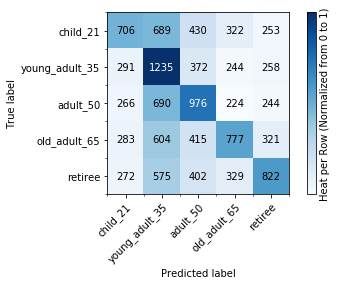

[[ 802  360  380  350  508]
 [ 327  852  474  319  428]
 [ 300  290 1114  274  422]
 [ 300  278  410  917  495]
 [ 283  205  338  347 1227]]
Normalized confusion matrix


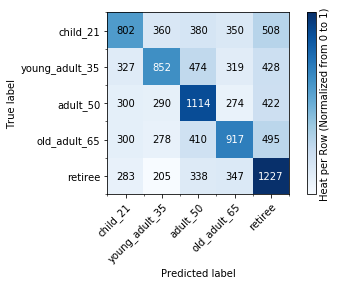

[[3934 2066]
 [2312 3688]]
Normalized confusion matrix


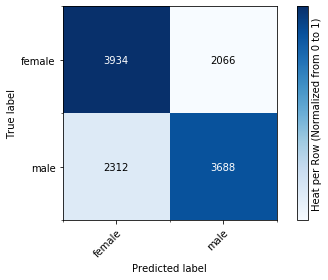

[[399 360 380 350 508]
 [327 327 474 319 428]
 [300 290 420 274 422]
 [300 278 410 323 495]
 [283 205 338 347 518]]
Normalized confusion matrix


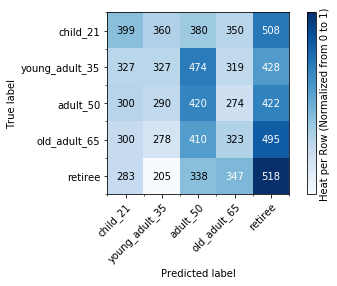

[[2505 2066]
 [2312 2192]]
Normalized confusion matrix


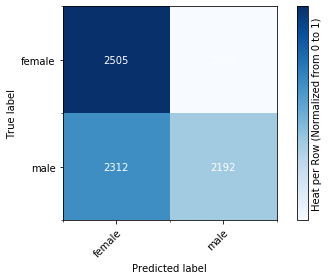

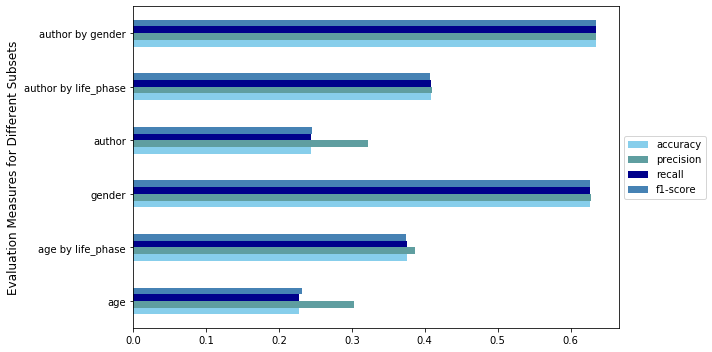

In [44]:

for st in subsets:
    for ana in subana:
        an = ana.split('/')[0]
        tmp = []
        index = []
        for label in labels:
            comp = {'accuracy': accuracy_score(df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_'+label],
                                          df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_'+label+'_pred']).round(3),
                    'precision': precision_score(df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_'+label],
                                          df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_'+label+'_pred'],
                                             average='weighted').round(3),
                    'recall': recall_score(df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_'+label],
                                          df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_'+label+'_pred'],
                                             average='weighted').round(3),
                    'f1-score': f1_score(df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_'+label],
                                          df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_'+label+'_pred'],
                                             average='weighted').round(3),
                   }
            tmp.append(comp)
            index.append(label)
            
            if label == 'age':
                
                comp = {'accuracy': accuracy_score(df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase'],
                                          df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase_pred']).round(3),
                    'precision': precision_score(df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase'],
                                          df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase_pred'],
                                             average='weighted').round(3),
                    'recall': recall_score(df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase'],
                                          df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase_pred'],
                                             average='weighted').round(3),
                    'f1-score': f1_score(df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase'],
                                          df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase_pred'],
                                             average='weighted').round(3)
                       }
                    
                tmp.append(comp)
                index.append('age by life_phase')
                
                np.set_printoptions(precision=2)
                cnf_matrix = confusion_matrix(df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase'],
                                             df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase_pred'],
                                             labels=phases)
                f = plt.figure()
                ax = f.subplots()
                plot_confusion_matrix(cnf_matrix, classes=phases,title=None, ax=ax)
                plt.show()
                #f.savefig('../Data/results/heatmaps/test.png')
                #f.savefig('../Data/results/heatmaps/cm_{st}_{an}_{label}_{group}.jpg'.format(st = st,
                                                                                              #an=an,
                                                                                              #label=label,
                                                                                              #group='life_phase'))
                plt.close()
                
                
                    
            if label == 'author':
                gen_pred_auth = []
                life_ph_pred_auth = []
                gen_pred_auth_wrong = []
                life_ph_pred_auth_wrong = []
                auth = list(df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_author_pred'])
                sub_wrong = df_dic[st][an]['df'].loc[df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_author_pred'] != df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_author']]                
                auth_sub_wrong = list(sub_wrong[an+'_'+str(st)+'_SVM_author_pred'])
                
                for au in auth:
                    gen_pred_auth.append(author_dic[st][an][au]['gender'])
                    life_ph_pred_auth.append(author_dic[st][an][au]['life_phase'])
                    
                for au in auth_sub_wrong:
                    gen_pred_auth_wrong.append(author_dic[st][an][au]['gender'])
                    life_ph_pred_auth_wrong.append(author_dic[st][an][au]['life_phase']) 
                    
                    
                comp = {'accuracy': accuracy_score(df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase'],
                                                   life_ph_pred_auth).round(3),
                    'precision': precision_score(df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase'],
                                                 life_ph_pred_auth,average='weighted').round(3),
                    'recall': recall_score(df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase'],
                                           life_ph_pred_auth,average='weighted').round(3),
                    'f1-score': f1_score(df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase'],
                                         life_ph_pred_auth,average='weighted').round(3)
                       }
                    
                tmp.append(comp)
                index.append('author by life_phase')
                
                cnf_matrix = confusion_matrix(df_dic[st][an]['df'][an+'_'+str(st)+'_life_phase'],
                                             life_ph_pred_auth,
                                             labels=phases)
                f = plt.figure()
                plot_confusion_matrix(cnf_matrix, classes=phases,title=None)
                plt.show()
                #f.savefig('../Data/results/heatmaps/cm_{st}_{an}_{label}_{group}.png'.format(st = st, an=an,
                                                                                              #label=label,
                                                                                              #group='life_phase'))
                
                comp = {'accuracy': accuracy_score(df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_gender'],
                                                   gen_pred_auth).round(3),
                    'precision': precision_score(df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_gender'],
                                          gen_pred_auth,
                                             average='weighted').round(3),
                    'recall': recall_score(df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_gender'],
                                          gen_pred_auth,
                                             average='weighted').round(3),
                    'f1-score': f1_score(df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_gender'],
                                          gen_pred_auth,
                                             average='weighted').round(3)
                       }
                    
                tmp.append(comp)
                index.append('author by gender')
                    
                cnf_matrix = confusion_matrix(df_dic[st][an]['df'][an+'_'+str(st)+'_SVM_gender'],
                                             gen_pred_auth,
                                             labels=['female', 'male'])
                f = plt.figure()
                plot_confusion_matrix(cnf_matrix, classes=['female', 'male'],title=None)
                plt.show()
                #f.savefig('../Data/results/heatmaps/cm_{st}_{an}_{label}_{group}.png'.format(st = st, an=an,
                                                                                              #label=label,
                                                                                              #group='gender'))
                
                ###make author cmap showing whether the author missclassified
                ##were confused with authors of similar gender or life_phase
                cnf_matrix = confusion_matrix(sub_wrong[an+'_'+str(st)+'_life_phase'],
                                             life_ph_pred_auth_wrong,
                                             labels=phases)
                f = plt.figure()
                plot_confusion_matrix(cnf_matrix, classes=phases,title=None)
                plt.show()
                #f.savefig('../Data/results/heatmaps/cm_{st}_{an}_{label}_{group}_false.png'.format(st = st, an=an,
                                                                                              #label=label,
                                                                                              #group='life_phase'))                
                
                
                cnf_matrix = confusion_matrix(sub_wrong[an+'_'+str(st)+'_SVM_gender'],
                                             gen_pred_auth_wrong,
                                             labels=['female', 'male'])
                f = plt.figure()
                plot_confusion_matrix(cnf_matrix, classes=['female', 'male'],title=None)
                plt.show()
                #f.savefig('../Data/results/heatmaps/cm_{st}_{an}_{label}_{group}_false.png'.format(st = st, an=an,
                                                                                              #label=label,
                                                                                              #group='gender'))                
                                
                
                
                
                
                
        f= plt.figure(figsize=(10,5))
        tmp_df =pd.DataFrame(tmp, index = index)
        tmp_df.plot(kind='barh', colormap = cmap, ax=f.gca())
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) #legend outside box
        plt.ylabel(ylabel='Evaluation Measures for Different Subsets',fontsize ='large', fontweight='roman')
        plt.tight_layout()
        #plt.savefig('../Data/results/barplots/overall_scores.png')
            



Make plots with most predicitve features

-0.419
-0.346
-0.356
-0.397
-0.508
-0.19
-0.6
-0.386
-0.529
-0.369
-0.453
-0.395
-0.407
-0.521
-0.515
-0.45
-0.477
-0.426
-0.499
-0.483
-0.486
-0.333
-0.506
-0.412
-0.424
-0.514
-0.544
-0.324
-0.462
-0.46
-0.516
-0.186
-0.41
-0.338
-0.313
-0.365
-0.44
-0.383
-0.592
-0.571
-0.371
-0.514
-0.451
-0.282
-0.559
-0.508
-0.403
-0.427
-0.519
-0.424
-0.48
-0.517
-0.402
-0.431
-0.3
-0.408
-0.504
-0.495
-0.541
-0.409
-0.453
-0.567
-0.244
-0.279
-0.265
-0.365
-0.335
-0.363
-0.551
-0.369
-0.349
-0.403
-0.702
-0.321
-0.315
-0.162
-0.421
-0.512
-0.274
-0.598
-0.483
-0.451
-0.56
-0.536
-0.566
-0.454
-0.379
-0.552
-0.498
-0.668
-0.408
-0.443
-0.567
-0.528
-0.434
-0.563
-0.472
-0.329
-0.379
-0.404
-0.363
-0.449
-0.32
-0.368
-0.305
-0.302
-0.533
-0.457
-0.281
-0.504
-0.384
-0.413
-0.472
-0.315
-0.485
-0.349
-0.376
-0.262
-0.529
-0.372
-0.433
-0.422
-0.227
-0.463
-0.314
-0.293
-0.214
-0.302
-0.27
-0.438
-0.347
-0.256
-0.436
-0.454
-0.374
-0.355
-0.502
-0.436
-0.491
-0.395
-0.215
-0.002
-0.398
-0.389
-0.45

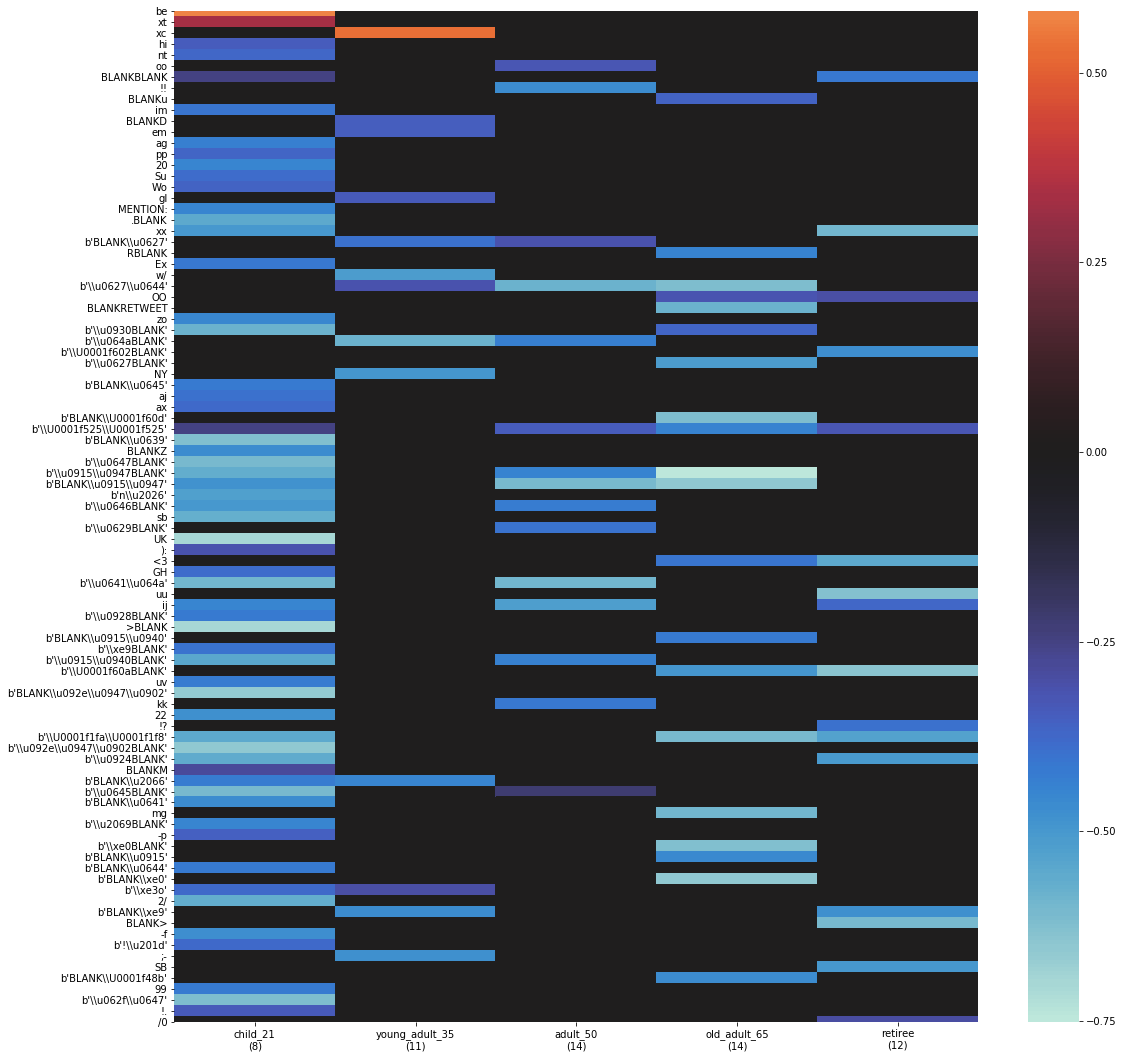

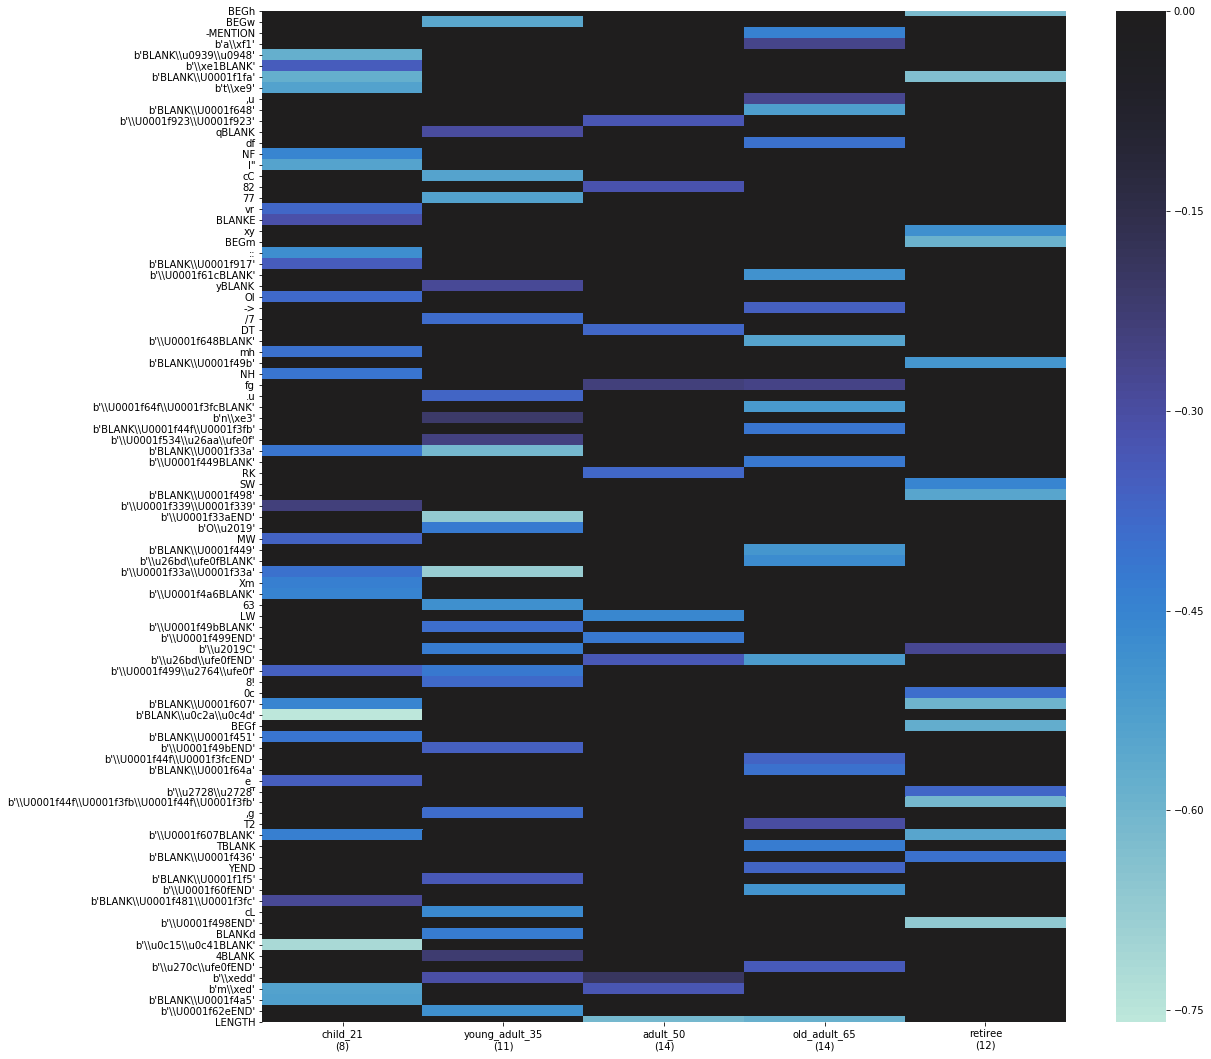

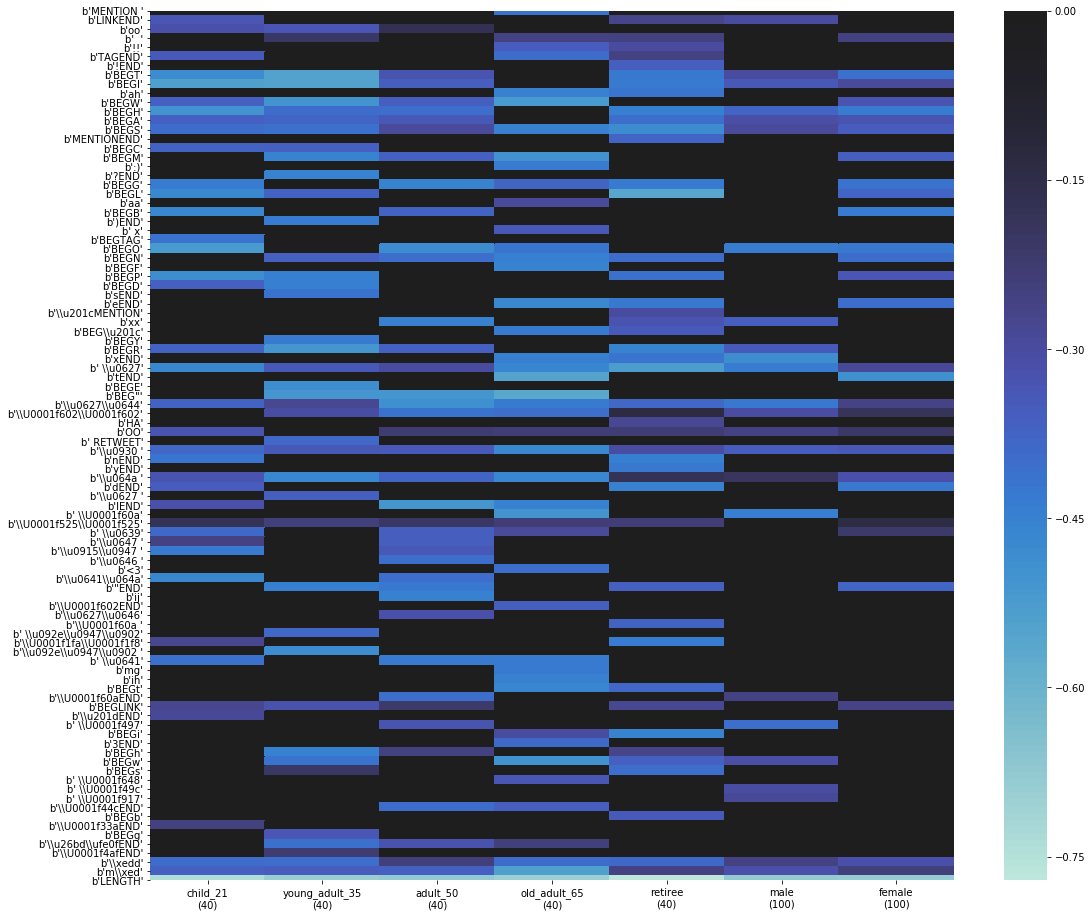

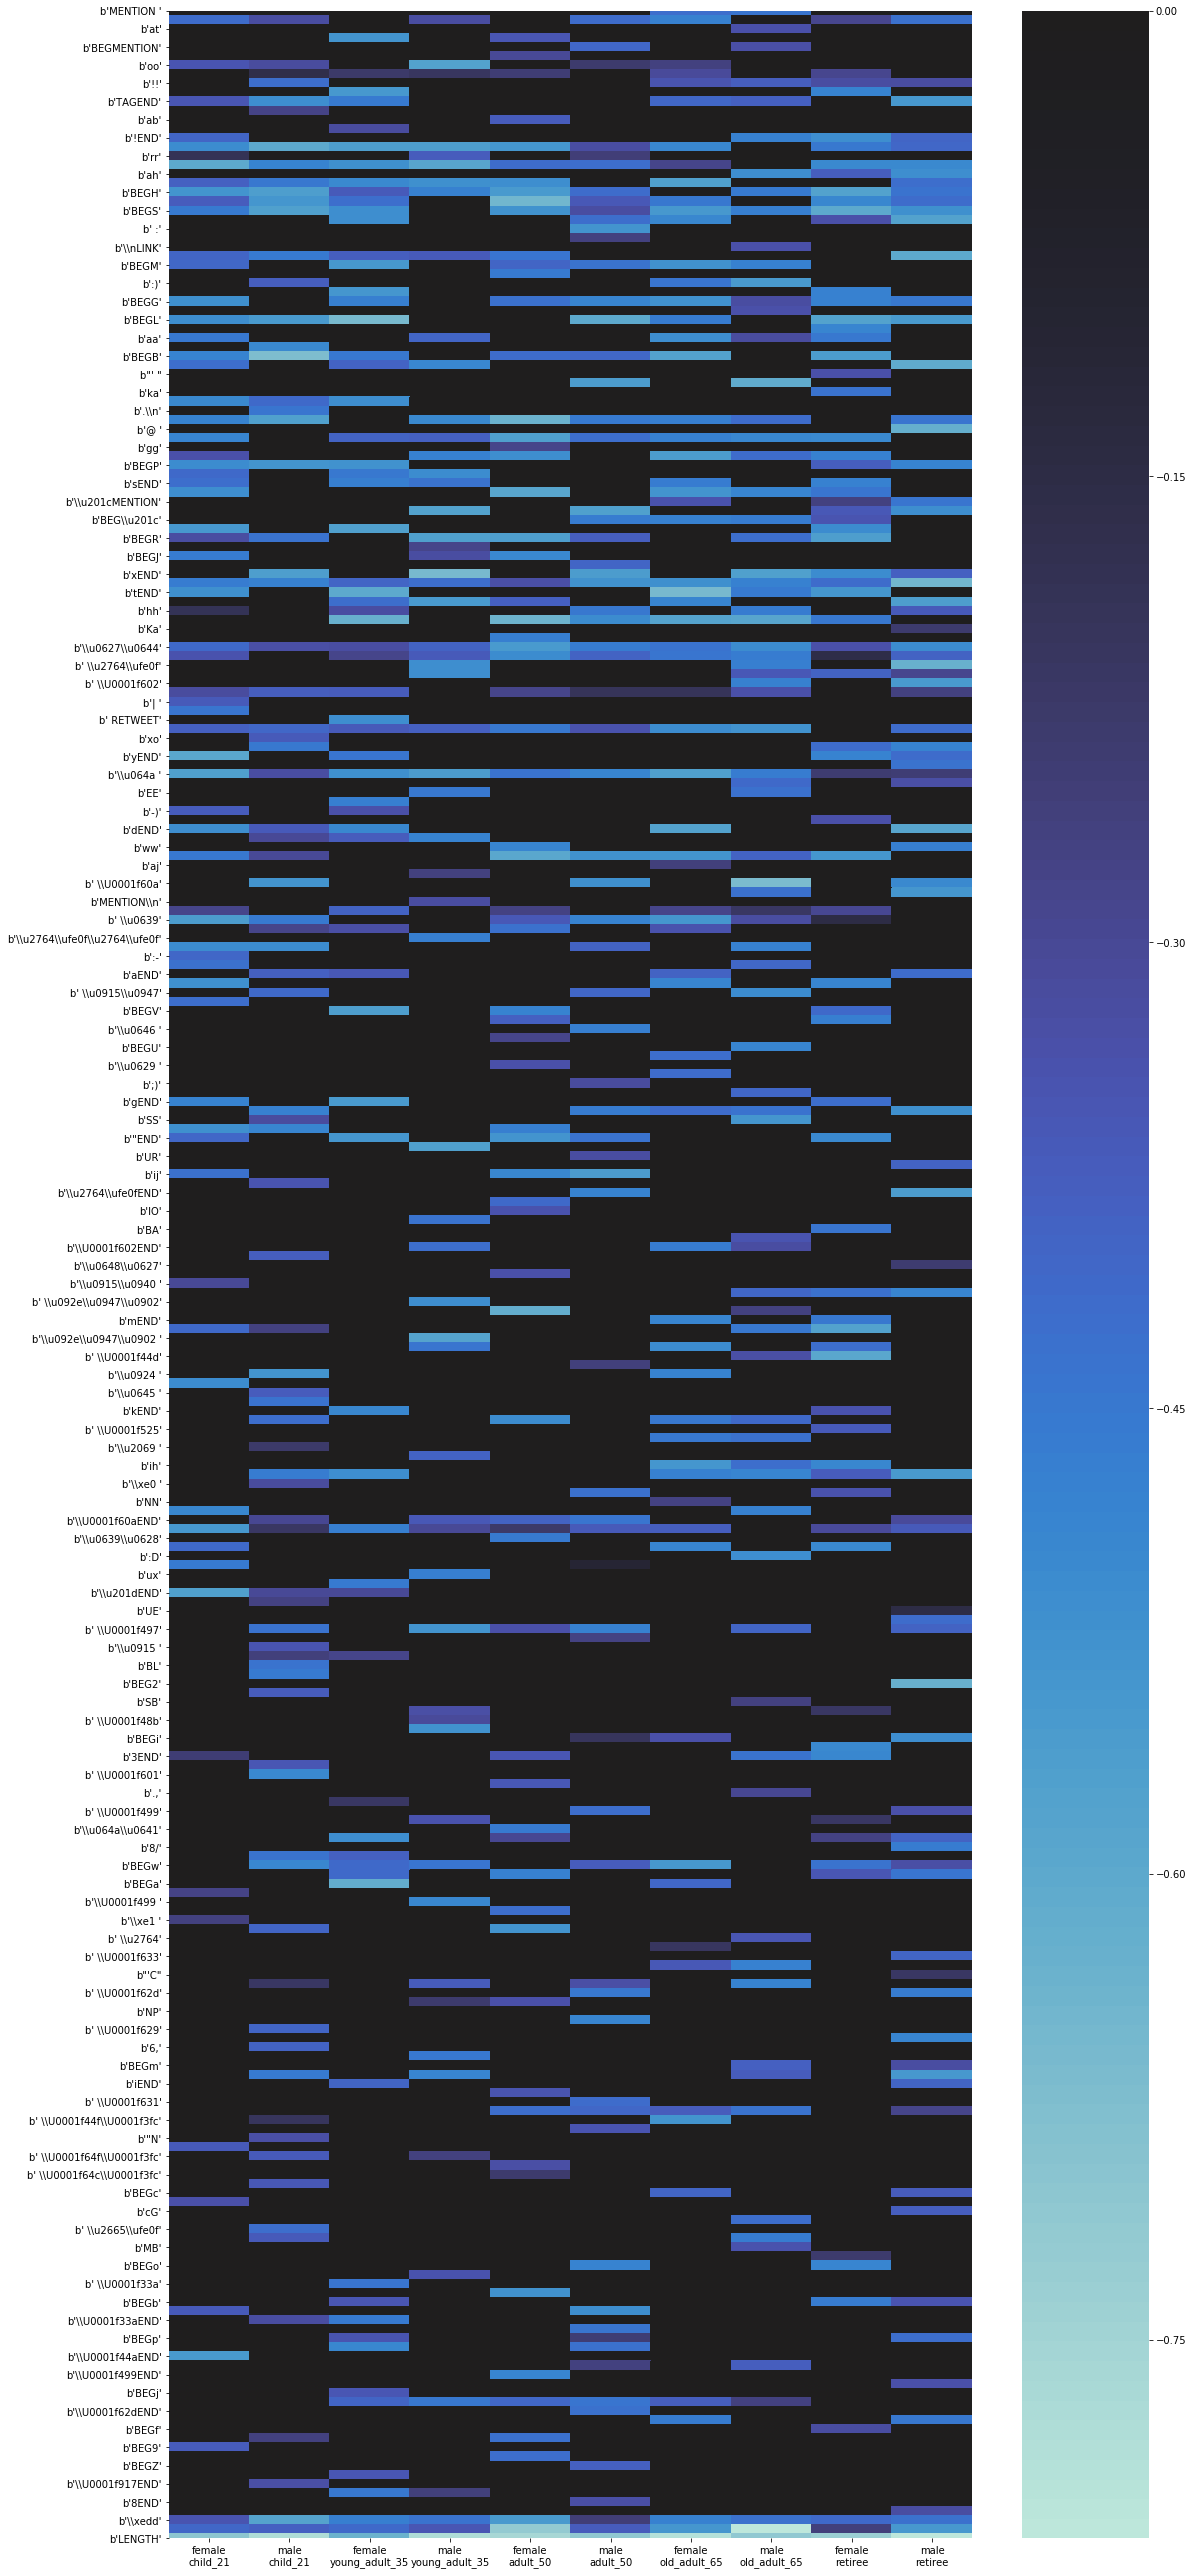

In [55]:
#import matplotlib as mpl
#mpl.rcParams['font.sans-serif'] = ['Segoe UI Emoji']
#mpl.rcParams['font.serif'] = ['Segoe UI Emoji']
import seaborn as sns # data visualization library  
#sns.set_style({"font.sans-serif":['Segoe UI Emoji']}) 
for st in subsets:
    for ana in subana:
        an = ana.split('/')[0]
        vocab = res_dic[st][an]['vocab_inverse']
        for label in labels:
            dic = {}
            ind_pos = []
            ind_neg = []
            if label == 'age':
                phase_key = []
                for ph in phases:
                        
                    leng = most_pred[st][an][label][ph]['number']
                    #print(most_pred[st][an][label][ph])
                    #print(leng)
                    arr = most_pred[st][an][label][ph]['val_array']
                    maxi = most_pred[st][an][label][ph]['max_array']
                    mini = most_pred[st][an][label][ph]['min_array']
                    ##make it so that the values of heat are relatively to the min and max values of the feature
                    dic[ph+'\n({})'.format(leng)] = {el[0]:(arr[el[0]]/maxi[el[0]]).round(3) for el in most_pred[st][an][label][ph]['count_tot_pos'] if (el[1]/leng) >= .95}
                    dic[ph+'\n({})'.format(leng)].update({el[0]:-(abs(arr[el[0]])/abs(mini[el[0]])).round(3) for el in most_pred[st][an][label][ph]['count_tot_neg'] if (el[1]/leng) >= .95})        
                    ind_pos.extend([el[0] for el in most_pred[st][an][label][ph]['count_tot_pos'] if (el[1]/leng) >= .95])
                    ind_neg.extend([el[0] for el in most_pred[st][an][label][ph]['count_tot_neg'] if (el[1]/leng) >= .95]) 
                    phase_key.append(ph+'\n({})'.format(leng))
                ind_pos = list(np.unique(ind_pos))
                ind_neg = list(np.unique(ind_neg))
                        
                tmp = {}
                for ph in phase_key:
                    tmp_l = []
                    for el in ind_pos+ind_neg:
                        try:
                            tmp_l.append(dic[ph][el])
                        except:
                            tmp_l.append(0)
                    tmp[ph] = tmp_l
                    
                #print([vocab[el] for el in ind_pos + ind_neg])
                ind = [vocab[el].replace('§', '') for el in ind_pos+ind_neg]
                ind = [re.sub(r'\s', 'BLANK', el) for el in ind]
                ind = [el.replace('$', r'\$') for el in ind]
                ind = [el.replace('\n', 'BREAK') for el in ind]
                #print(ind)
                for i in range(0, len(ind)):
                    try:
                        ind[i].encode('ascii')
                    except:
                        ind[i] = ind[i].encode('unicode-escape')
                    
                        
                df = pd.DataFrame(tmp , index = ind)
                ##select only informative features (i.e. those which are 0 across less than all columns of type)
                mask = (df == 0.0).T
                ls = []
                for col in mask.columns:
                    if collections.Counter(mask[col])[True] < 1:
                        ls.append(col)
                df.drop(ls, inplace = True)


                ###plot is too long - half it
                half = math.floor(len(df.index)/2)
                    
                sub = df[0:half]
                f,ax = plt.subplots(figsize=(18, len(ind_pos+ind_neg)/10))
                sns.heatmap(sub, fmt= '.1f',ax=ax, center = 0, yticklabels = True)
                #f.savefig(savedir+'featureplots/features_heat_{}_{}_{}_phases_1.pdf'.format(st, an, label))
                #f.savefig(savedir+'featureplots/features_heat_{}_{}_{}_phases_1.png'.format(st, an, label))
                sub = df[half:]
                f,ax = plt.subplots(figsize=(18, len(ind_pos+ind_neg)/10))
                sns.heatmap(sub, fmt= '.1f',ax=ax, center = 0, yticklabels = True)
                #f.savefig(savedir+'featureplots/features_heat_{}_{}_{}_phases_2.pdf'.format(st, an, label))
                #f.savefig(savedir+'featureplots/features_heat_{}_{}_{}_phases_2.png'.format(st, an, label))
                
            elif label == 'author':
                sex_key = []
                phase_key = []
                for sex in ['male', 'female']:
                    leng = most_pred[st][an][label][sex]['number']
                    arr = most_pred[st][an][label][sex]['val_array']
                    maxi = most_pred[st][an][label][sex]['max_array']
                    mini = most_pred[st][an][label][sex]['min_array']
                    ##make it so that the values of heat are relatively to the min and max values of the feature
                    dic[sex+'\n({})'.format(leng)] = {el[0]:(arr[el[0]]/maxi[el[0]]).round(3) for el in most_pred[st][an][label][sex]['count_tot_pos'] if (el[1]/leng) >= .95}
                    dic[sex+'\n({})'.format(leng)].update({el[0]:-(abs(arr[el[0]])/abs(mini[el[0]])).round(3) for el in most_pred[st][an][label][sex]['count_tot_neg'] if (el[1]/leng) >= .95})        
                    ind_pos.extend([el[0] for el in most_pred[st][an][label][sex]['count_tot_pos'] if (el[1]/leng) >= .95])
                    ind_neg.extend([el[0] for el in most_pred[st][an][label][sex]['count_tot_neg'] if (el[1]/leng) >= .95]) 
                    sex_key.append(sex+'\n({})'.format(leng))

                for ph in phases:
                    leng = most_pred[st][an][label][ph]['number']
                    arr = most_pred[st][an][label][ph]['val_array']
                    maxi = most_pred[st][an][label][ph]['max_array']
                    mini = most_pred[st][an][label][ph]['min_array']
                    ##make it so that the values of heat are relatively to the min and max values of the feature
                    dic[ph+'\n({})'.format(leng)] = {el[0]:(arr[el[0]]/maxi[el[0]]).round(3) for el in most_pred[st][an][label][ph]['count_tot_pos'] if (el[1]/leng) >= 0.95}
                    dic[ph+'\n({})'.format(leng)].update({el[0]:-(abs(arr[el[0]])/abs(mini[el[0]])).round(3) for el in most_pred[st][an][label][ph]['count_tot_neg'] if (el[1]/leng) >= .95})        
                    ind_pos.extend([el[0] for el in most_pred[st][an][label][ph]['count_tot_pos'] if (el[1]/leng) >= .95])
                    ind_neg.extend([el[0] for el in most_pred[st][an][label][ph]['count_tot_neg'] if (el[1]/leng) >= .95]) 
                    phase_key.append(ph+'\n({})'.format(leng))
                ind_pos = list(np.unique(ind_pos))
                ind_neg = list(np.unique(ind_neg))
                
                tmp = {}
                for ph in phase_key+sex_key:
                    tmp_l = []
                    for el in ind_pos+ind_neg:
                        try:
                            tmp_l.append(dic[ph][el])
                        except:
                            tmp_l.append(0)
                    tmp[ph] = tmp_l
                                      
                    
                ind = ind_pos+ind_neg
                #print([vocab[el] for el in ind_pos + ind_neg])
                df = pd.DataFrame(tmp, index = [vocab[el].replace('§', '').encode('unicode-escape') for el in ind])
                f,ax = plt.subplots(figsize=(18, len(ind_pos+ind_neg)/6))
                sns.heatmap(df, fmt= '.1f',ax=ax, center = 0, yticklabels = True)
                f.savefig('../Data/results/featureplots/features_heat_{}_{}_{}_phases.png'.format(st, an, label))
                
                dic = {}
                ind_pos = []
                ind_neg = []
                phase_key = []
                for ph in phases:
                    for sex in ['female', 'male']:
                        leng = most_pred[st][an][label][ph][sex]['number']
                        arr = most_pred[st][an][label][ph][sex]['val_array']
                        maxi = most_pred[st][an][label][ph][sex]['max_array']
                        mini = most_pred[st][an][label][ph][sex]['min_array']
                        ##make it so that the values of heat are relatively to the min and max values of the feature
                        dic[sex+'\n'+ph] = {el[0]:(arr[el[0]]/maxi[el[0]]).round(3) for el in most_pred[st][an][label][ph][sex]['count_tot_pos'] if (el[1]/leng) >= 0.95}
                        dic[sex+'\n'+ph].update({el[0]:-(abs(arr[el[0]])/abs(mini[el[0]])).round(3) for el in most_pred[st][an][label][ph][sex]['count_tot_neg'] if (el[1]/leng) >= .95})        
                        ind_pos.extend([el[0] for el in most_pred[st][an][label][ph][sex]['count_tot_pos'] if (el[1]/leng) >= .95])
                        ind_neg.extend([el[0] for el in most_pred[st][an][label][ph][sex]['count_tot_neg'] if (el[1]/leng) >= .95])                
                        phase_key.append(sex+'\n'+ph)
                ind_pos = list(np.unique(ind_pos))
                ind_neg = list(np.unique(ind_neg))
                #print(ind_pos+ind_neg)
                #print(dic)
                tmp = {}
                for ph in phase_key:
                    tmp_l = []
                    for el in ind_pos+ind_neg:
                        try:
                            print(dic[ph][el])
                            tmp_l.append(dic[ph][el])
                        except:
                            tmp_l.append(0)
                    tmp[ph] = tmp_l                                    
                ind = ind_pos+ind_neg
                print(tmp)
                df = pd.DataFrame(tmp, index = [vocab[el].replace('§', '').encode('unicode-escape') for el in ind])
                #print(df.head())
                f,ax = plt.subplots(figsize=(18, len(ind_pos+ind_neg)/6))
                sns.heatmap(df, fmt= '.1f',ax=ax,center = 0)
                #f.savefig('../Data/results/featureplots/features_heat_{}_{}_{}_gender_phases.png'.format(st, an, label))                      
                        